# 実践コンピュータビジョン
# 4章 カメラモデルと拡張現実感
## 4.1 ピンホールカメラ
テキスト p.81

### 4.1.2 3Dの点の射影
カメラと射影をモデル化するために必要な処理を行うCameraクラスを作る。  
ここでは * を使ったimportを避けて、名前空間を設定する。

In [23]:
import numpy as np
from scipy import linalg
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
import camera

### 建物の画像の3Dモデリング

オックスフォード大学データセットのうち、"Model House"を用いる。  
http://www.robots.ox.ac.uk/~vgg/data/data-mview.html

---
ファイルの内訳：
- house.###.P: 3x4 camera projection matrix, one per image.
- house.p3d:    3D points. ASCII x y z coordinates, one per line
- house.l3d:     3D line segments. ASCII x0 y0 z0 x1 y1 z1 one per line


In [25]:
# 点群データを読み込む
# house.p3d は　672 x 3 のデータを含むテキストデータ
# (x, y, z)で並んでいる3D座標
points = np.loadtxt('3D/house.p3d').T
print(points.shape)
print('[x1,y1,z1] =', points[:,0])

(3, 672)
[x1,y1,z1] = [-1.4889   1.09408 -5.89588]


In [26]:
points[:,:5]

array([[-1.4889  , -1.13932 ,  1.09404 , -1.26433 , -1.55242 ],
       [ 1.09408 ,  0.935522,  0.738447,  0.278026, -0.132491],
       [-5.89588 , -5.62824 , -4.53106 , -5.4722  , -5.84788 ]])

In [27]:
# 同次座標にするため1 x 672 の行を追加する
points = np.vstack((points, np.ones(points.shape[1])))
points.shape

(4, 672)

In [28]:
# カメラ行列Pの初期値を作成する
# P[2,3] = -10とする理由がわからない
P = np.hstack((np.eye(3), np.array([[0],[0],[-10]])))
print(P.shape)
print(P[2,3])

(3, 4)
-10.0


In [29]:
#　Cameraインスタンスを作る
cam = camera.Camera(P)
x = cam.project(points)
x.shape

(3, 672)

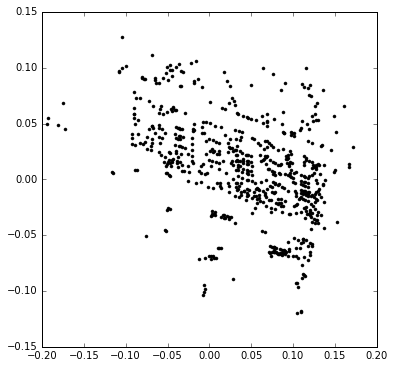

In [30]:
# 射影を描画する
plt.figure(figsize=(6,6))
plt.plot(x[0], x[1], 'k.')
plt.show()

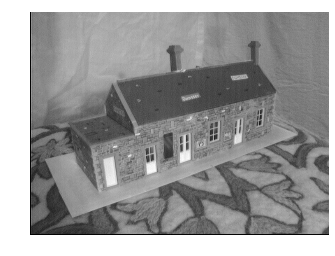

In [31]:
img = np.array(Image.open('images/house.000.pgm'))
plt.gray()
plt.imshow(img)
plt.axis('off')
plt.show()

In [32]:
# 変換行列を作る
r = 0.05 * np.random.rand(3)
rot = camera.rotation_matrix(r)
print(rot)

[[ 0.99876216 -0.01925403  0.04586328  0.        ]
 [ 0.02082282  0.99920566 -0.03397726  0.        ]
 [-0.04517265  0.03489021  0.99836972  0.        ]
 [ 0.          0.          0.          1.        ]]


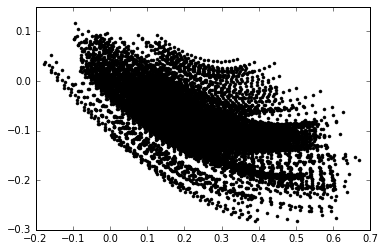

In [33]:
# カメラを回転して射影する
plt.figure()
for t in range(20):
    cam.P = np.dot(cam.P, rot)
    x = cam.project(points)
    plt.plot(x[0], x[1], 'k.')
plt.show()

### 4.1.3 カメラ行列の分解
RQ分解を用いて、カメラ行列Pから内部パラメータK、カメラの位置ベクトルt、姿勢Rを算出する。

Reference: linalg.rq


In [34]:
K = np.array([[1000, 0, 500], [0, 1000, 300], [0, 0, 1]])
tmp = camera.rotation_matrix([0,0,1])[:3,:3]
Rt = np.hstack((tmp, np.array([[50],[40],[30]])))
cam = camera.Camera(np.dot(K, Rt))

K1, R1, t1 = cam.factor()
print('K=', K)
print('Rt=',Rt)
print('K1=',K1)
print('R1=',R1)
print('t1=',t1)

K= [[1000    0  500]
 [   0 1000  300]
 [   0    0    1]]
Rt= [[  0.54030231  -0.84147098   0.          50.        ]
 [  0.84147098   0.54030231   0.          40.        ]
 [  0.           0.           1.          30.        ]]
K1= [[ 1000.     0.   500.]
 [    0. -1000.   300.]
 [    0.     0.     1.]]
R1= [[ 0.54030231 -0.84147098  0.        ]
 [-0.84147098 -0.54030231  0.        ]
 [ 0.          0.          1.        ]]
t1= [ 50. -40.  30.]


カメラに設定したK、Rtと、factor()を使って分解したK1、R1、t1が同じであることが確認できる。

In [35]:
P0 = np.dot(K, Rt)
# factor first 3*3 part
K0,R0 = linalg.rq(P0[:,:3])
print(K0)
print(R0)

[[ 1000.     0.   500.]
 [    0. -1000.   300.]
 [    0.     0.     1.]]
[[ 0.54030231 -0.84147098  0.        ]
 [-0.84147098 -0.54030231  0.        ]
 [-0.         -0.          1.        ]]


np.sign(T): 行列Tの各要素の正負を抽出して、mxnの行列を作る

In [36]:
np.diag(K0)

array([ 1000., -1000.,     1.])

np.diag(T): 行列Tの対角成分を抽出して、1xnのベクトルを作る

In [37]:
np.sign(K0)

array([[ 1.,  0.,  1.],
       [ 0., -1.,  1.],
       [ 0.,  0.,  1.]])

In [38]:
# make diagonal of K positive
T0 = np.diag(np.sign(np.diag(K0)))
T0

array([[ 1.,  0.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])

In [39]:
# T０の行列式は負になるので、符号を変える
print(linalg.det(T0))
if linalg.det(T0) < 0:
    T0[1,1] *= -1
T0

-1.0


array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [40]:
K0t = np.dot(K0,T0)
R0t = np.dot(T0,R0) # T is its own inverse
tt = np.dot(linalg.inv(K0),P0[:,3])

In [41]:
K0t

array([[ 1000.,     0.,   500.],
       [    0., -1000.,   300.],
       [    0.,     0.,     1.]])